# Analysing SBN: SG with scaled BN over image and language models

Hidden size in all experiments is 200

In [2]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
import retriever
from tabulate import tabulate
from matplotlib import gridspec
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/_test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/SBN/'
embed_path =  '../data/metadata/w2v.bin'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spaital features]. Note that different enteries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the ture bbox </li>
</ul>

In [4]:
trainset = np.load(open(trainset_file, 'rb'))
print('All Train set data size:',len(trainset))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])
print('Good Train set data size:',len(trainset))

testset = np.load(open(testset_file, 'rb'))
print('All Test set data size:', len(testset))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])
print('Good Test set data size:',len(testset))

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

All Train set data size: 59450
Good Train set data size: 59449
All Test set data size: 59507
Good Test set data size: 59507
Number of words: 8242


In [5]:
# w2c words vectors
embed_vecs = np.load(open(embed_path, 'rb')).astype(np.float32)

In [6]:
def stats(test, train, ephocs=100, title=None, params=[50, 100, 150, 200], path=None):
    '''
    Plot metrics graphs and print some stats.
    
    Params:
        test: list. 
              Each item is a tuple, [test accuracy, test IOU, test loss]
        
        train: list. 
               Each item is a tuple, [train accuracy, train IOU, train loss, 0]
               For now we can ignore the last part in the tuple (zero)
               
        params: The hyper-parameters to iterate over, defult to number of rnn's hidden units.
        
        path: Where to save the graphs image. If none, do not save. 
        '''
    
    ephocs = range(ephocs)
    test_res = np.array(test)
    train_res = np.array(train)
    test_Glabels = ['test accuracy', 'test IOU', 'test loss']
    train_Glabels = ['train accuracy', 'train IOU', 'train loss']
    figs = []
    
    
    for j, param in enumerate(params):
        f, P = plt.subplots(1, 3, figsize=(12,4))
       
        for i in range(len(train_Glabels)):
            P[i].plot(ephocs, test_res[j][:,i])
            P[i].plot(ephocs, train_res[j][:,i])
            P[i].legend([test_Glabels[i], train_Glabels[i]], loc=0)
            if title is not None:
                P[i].set_title('%s'%(title))

            metric = ''.join(train_Glabels[i][len('train')+1:])
            if metric=='loss':
                print('Train loss %s:%.3f'%(metric, min(train_res[j][:,i])))
                print('Test loss %s:%.3f'%(metric, min(test_res[j][:,i])))
            else:
                print('Train %s:%.3f'%(metric, max(train_res[j][:,i])))
                print('Test %s:%.3f'%(metric, max(test_res[j][:,i])))
            P[i].plot()
        plt.show()
        
        if path is not None:
            f.savefig(path+str(params[j])+'_plot.png')
        figs.append(f)
        print('-'*100,'\n')
    return figs

# ALSTM

ALSTM is an LSTM cell that is able to attened over the BBOXes at each timestep

In [7]:
class ALSTM(tf.nn.rnn_cell.LSTMCell):
    def __init__(self, 
                 batch_size, 
                 num_units, 
                 
                 # Size of attention vector ([image vector, spital features] size) .
                 img_attn_dim, 
                 # Attention vectors
                 img_attn_states, 
                 # img_attn_idx[i,j]=0 if the i-th vector in img_attn_states
                 # is a padding vector
                 img_attn_idx, 
                 # Dropout ratio for rnn's inputs and outpouts
                 dropout_out=1.,
                 dropout_in=1.,
                 state_is_tuple=True):
        
        super().__init__(num_units, state_is_tuple=state_is_tuple)
    
        self.img_attn_states = img_attn_states
        self.img_attn_idx = img_attn_idx
        self.img_attn_dim = img_attn_dim
        
        self.num_units = num_units
        self.batch_size = batch_size
        cell = tf.nn.rnn_cell.LSTMCell(self.num_units, state_is_tuple=True)
        
        self.cell = tf.contrib.rnn.DropoutWrapper(
                    cell, output_keep_prob=dropout_out, input_keep_prob=dropout_in)

    def call(self, inputs, state):
        # attention over the BBOXes
        words_attn = self.attention(state[1], self.img_attn_states, self.img_attn_dim, self.img_attn_idx)
        new_input = tf.concat([inputs, words_attn], -1)
        outputs, new_state = self.cell(new_input, state)
        
        return outputs, new_state
    
    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):
        with tf.variable_scope(scope, reuse=False):
            W = tf.get_variable('W', initializer=tf.random_uniform_initializer(maxval=1., minval=-1.),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W) + b

        return tf.matmul(inputs, W)
    
    
    def attention(self, state, attn_states, attn_dim, attn_idx, relu=False):
        '''
        Attention mechanism (see https://arxiv.org/pdf/1409.0473.pdf)
        
        state: State from previous time step.
        attn_states: Attetntion states. 
                     Tensor of shape (batch_size x max([len(attention_vectors[i]) for i in range(batch_size)]) x attn_dim)
        attn_dim: Attention vector size.
        attn_idx,: Tensor used for masking of shape (batch_size x max([len(attention_vectors[i]) for i in range(batch_size)]). 
                   attn_idx[i, j]=1 if the j's attention vcctior of sample i  is not padding, else its equat to 0.
        '''
        with tf.variable_scope('attn'):
            self.attn_length = tf.shape(attn_states)[1]  

            '''
            Computing... hidden_attn = W*v_att (use tf.nn.conv2d for efficiency)
            '''
            # Conv input
            attn_vecs = tf.reshape(
                attn_states, [self.batch_size, self.attn_length, 1, attn_dim]
            )
            # Filter
            W = tf.get_variable("attn_W", [1, 1, attn_dim, self.num_units])
            # hidden_attn shape: (batch_size x attn_length x 1 x num_units)
            hidden_attn = tf.nn.conv2d(attn_vecs, W, [1, 1, 1, 1], "SAME") 

            '''
            Computing... hidden_s = U*v_state
            '''
            # Shape: batch_size x 1 x 1 x num_units
            hidden_s = tf.reshape(
                self.linear(tf.cast(state, tf.float32), output_dim=self.num_units, scope='hidden_s_linear'), 
                [-1, 1, 1,  self.num_units], 
                name='hidden_s'
            )

            '''
            Computing logits...
            '''
            # Shape: batch_size x num_units
            v = tf.get_variable("attn_v", [self.num_units])
            if relu:
                logits = tf.reduce_sum(v * tf.nn.relu(hidden_attn + hidden_s), [2, 3])
            else:
                logits = tf.reduce_sum(v * tf.nn.tanh(hidden_attn + hidden_s), [2, 3])

            # Masked softmax
            max_logits = tf.reduce_max(logits, axis=-1)
            masked_logits = tf.exp(logits-tf.expand_dims(max_logits, axis=1))*attn_idx
            alpha = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            # a is the weighted sum of the attention vectors (multiplied by the weights (alpha)) 
            a = tf.reduce_sum(tf.reshape(alpha, [-1, self.attn_length, 1, 1]) * attn_vecs, [1, 2])
            
            # Project a to num_units dimention
            b = tf.contrib.layers.fully_connected(a, num_outputs=self.num_units)


            return b

In [8]:
class Model():
    def __init__(self,
                 batch_size, 
                 num_hidden, 
                 
                 #Image's vector size.
                 img_dims, 
                 
                 #Spaital features length.
                 bbox_dims, 
                 vocab, 
                 lr, #  learning rate.
                 decay_steps, 
                 decay_rate, 
                 
                 # whether to use batch normaliztion for the last attention layer
                 bnorm,
                 embed_size=embed_vecs.shape[1],
                 
                 # Whether to uses prefix levlel attention or not.
                 use_wordAttn=False,
                 
                 # Whther to use bidirectional rnn
                 useBidirectionalRnn=False,
                 
                 # Urnn_norm: Whether to use batch normalization for the queries.
                 # Uatt_norm: Whether to use batch normalization for the VGG outputs.
                 Urnn_norm=True, 
                 Uatt_norm=True,
                 
                 # We scale the VGG16 BN outputs by IMGscale
                 IMGscale=1,
                 # We scale the language BN outputs by Qscale
                 Qscale=1,
                ):
        
        self.batch_size = batch_size
        self.img_dims = img_dims
        self.bbox_dims = bbox_dims 
        self.num_hidden = num_hidden
        self.embed_size = embed_size
        self.vocab = vocab
        self.lr = lr
        self.bnorm=bnorm
        self.IMGscale=IMGscale
        self.Qscale=Qscale

        self.queries = tf.placeholder(tf.int32, [None, None], name='queries')
        self.img  = tf.placeholder(tf.float32, [None, None, self.img_dims], name='img')# VGG output vectors
        self.bboxes = tf.placeholder(tf.float32, [None, None, self.bbox_dims], name='bboxes')# spatial bbox's features.

        # attn_idx: inicates whether attention box is a pad (0) or not (1).
        self.attn_idx = tf.placeholder(tf.float32, [None, None], name='attn_idx')
        self.labels = tf.placeholder(tf.float32, [None, None], name='labels')
        
        # Dropout ratio for rnn's inputs and outpouts
        self.dropout_in = tf.placeholder(tf.float32, name='dropoutIn_holder')
        self.dropout_out = tf.placeholder(tf.float32, name='dropoutOut_holder')

        # Dropout ratio for attention vector (for the final attention layer before the loss function)
        self.dropout_img = tf.placeholder(tf.float32, name='dropoutImg_holder')
        # Dropout ratio for query vector (for the final attention layer before the loss function)
        self.dropout_q = tf.placeholder(tf.float32, name='dropoutImg_holder')

        self.isTrain = tf.placeholder(tf.bool, name='isTrain_holder') 
        self.queries_lens = self.length(self.queries) # list of all the lengths of the batch's queriey 

        # Concatinate images vectors and their spaital features. 
        # These vectors wlll be used for attenionn when 
        # we calculate the loss function.
        attn_vecs = tf.concat([self.img, self.bboxes], 2) 
        voc_size = len(self.vocab)

        # Load pre-trained word imaddings.
        # w2v_embed is not trainable.
        with tf.variable_scope('w2v'):
            w2v_embed = tf.get_variable('w2v_embed', initializer=embed_vecs, trainable=False)
            w2v_queries = tf.nn.embedding_lookup(w2v_embed, self.queries, name='w2v_queries')

        with tf.variable_scope('embed'):
            embed = tf.get_variable('embed', shape=[voc_size, self.embed_size], 
                                    initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1))
            embed_queries_tmp = tf.nn.embedding_lookup(embed, self.queries, name='embed_queries')

        embed_queries = embed_queries_tmp+w2v_queries

        with tf.variable_scope('rnn'):
            if use_wordAttn:
                cell = ALSTM(num_units=self.num_hidden, 
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            dropout_in=self.dropout_in, dropout_out=self.dropout_out)
            else:
                tmp = tf.nn.rnn_cell.LSTMCell(self.num_hidden, state_is_tuple=True)
                cell = tf.contrib.rnn.DropoutWrapper(
                    tmp, 
                    input_keep_prob=self.dropout_in, 
                    output_keep_prob=self.dropout_out
                )

            if useBidirectionalRnn:
                if use_wordAttn:
                    cell_bw = ALSTM(num_units=self.num_hidden, 
                            img_attn_dim=self.img_dims+self.bbox_dims,
                            img_attn_states=attn_vecs,
                            img_attn_idx=self.attn_idx,
                            batch_size=self.batch_size, 
                            dropout_in=self.dropout_in, dropout_out=self.dropout_out)
                else:
                    tmp_bw = tf.nn.rnn_cell.LSTMCell(self.num_hidden, state_is_tuple=True)
                    cell_bw = tf.contrib.rnn.DropoutWrapper(
                        tmp, 
                        input_keep_prob=self.dropout_in, 
                        output_keep_prob=self.dropout_out
                    )

                    
                self.outputs, self.last_states = tf.nn.bidirectional_dynamic_rnn(
                    cell_fw=cell,
                    cell_bw=cell_bw,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)

                state = tf.concat([self.last_states[0][1], self.last_states[1][1]], -1)
            
            else:
                self.outputs, self.last_states = tf.nn.dynamic_rnn(
                    cell=cell,
                    dtype=tf.float32,
                    sequence_length=self.queries_lens,
                    inputs=embed_queries)
                state = self.last_states[1]


        self.scores = self.bnorm_attention(state, Urnn_norm=Urnn_norm, Uatt_norm=Uatt_norm) 
        
        # Cross entophy loss for each of the queries in the batch.
        self.loss = tf.reduce_mean(-tf.reduce_sum(
                        self.labels*tf.log(self.scores+0.00000001)+
                            (1-self.labels)*tf.log((1-self.scores)+0.00000001), 
                        axis=-1))
        
        self.g_rnn =  tf.reduce_mean(tf.norm(tf.gradients(self.loss, self.Urnn)[0], axis=1))
        self.g_img =  tf.reduce_mean(
            tf.reduce_sum(
                tf.norm(
                    tf.gradients(self.loss, self.Uatt)[0]+0.0000000001, axis=2), axis=1)/tf.reduce_sum(self.attn_idx, 1))
        

        ##############
        # Optimizers #
        ##############

        starter_learning_rate = self.lr
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, 
                                                        self.global_step,
                                                        decay_steps=decay_steps, 
                                                        decay_rate=decay_rate, 
                                                        staircase=True)

        self.optimizer =  tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate).minimize(self.loss, global_step=self.global_step)  

        if not os.path.exists(params_dir):
                os.makedirs(params_dir)
        self.saver = tf.train.Saver()

        
    def length(self, seq):
        '''
        Retruns real lengths (before addings) of all queries in seq  .
        '''
        return tf.cast(tf.reduce_sum(tf.sign(tf.abs(seq)), reduction_indices=1), tf.int32)
       

    def linear(self, inputs, output_dim, scope='linear', bias=True, reuse=False):

        with tf.variable_scope(scope, reuse=reuse):
            W1 = tf.get_variable('W1', initializer=tf.contrib.layers.xavier_initializer(),
                                shape=(inputs.get_shape()[-1], output_dim))
            if bias:
                b = tf.get_variable('b', initializer=tf.constant_initializer(0.1),
                               shape=[1, output_dim])
                return tf.matmul(inputs, W1) + b
            
            return tf.matmul(inputs, W1)

            
    def pad_img(self, attn_vecs):
        '''
        Each query atteched to a different number of BBOXes, hence, 
        we've padded each query BBOXes candidates with zeros (in attn_vecs). When using 
        batch normlization, this might effect he mean and std which the BN calculates. Therefore, 
        we change the paddings s.t it won't affect the statistics. This is done 
        by:
        
            1. Let the i features set be the set of all the batch's BBOXes
               i dimension. We first calculate the std and mean of all the 
               values in this set which are not paddings.
               
            2. We build a random tensor (bbox_padded) with the shape of attn_vecs s.t in 
               its i features set, the sub-set of the values that correspond 
               to the padded values (in attn_vecs) will have the same mean and 
               std as calculated in 1. 
               
            3. We than replace only the padded features in attn_vecs by their correspond
               features in bbox_padded.
            
        It's easy to show mathematicly that bath normelizing the resulted tensor will have 
        the same effect as bath normelizing attn_vecs.
            
            
        Params:
            attn_vecs: bboxes vectors.
            
        Returns:
            new_attn_vecs: see above. 
            
        '''
        
        # Calculating the statistics of each features set
        bbox_dim = self.img_dims#+self.bbox_dims
        attnVecs = tf.reshape(attn_vecs, [-1, bbox_dim])
        
        # mask[i,j]=1 if the j-th BBOX in the i-th query is paddings, 
        # else its zero.
        mask = tf.reshape(self.attn_idx, [-1,1])
        mean = tf.reduce_sum(attnVecs, 0, keepdims=True)/tf.reduce_sum(mask, axis=0, keepdims=True)
        std = tf.sqrt(
            tf.reduce_sum(
                mask*((attnVecs-mean)**2)/tf.reduce_sum(mask, axis=0, keepdims=True),
                axis=0,
                keepdims=True)
        )
        
        
        # Building bbox_padded (see comment above)
        rand = tf.random_normal(shape=tf.shape(attnVecs))
        mean_r = tf.reduce_sum((1-mask)*rand, 0, keepdims=True)/tf.reduce_sum(1-mask+0.00000001, 0, keepdims=True)
        std_r = tf.sqrt(
            tf.reduce_sum(
                (1-mask)*((rand-mean_r)**2)/tf.reduce_sum(1-mask+0.00000001, axis=0, keepdims=True),
                axis=0,
                keepdims=True)
        )
        
        
        pad = std*(rand-mean_r)/(std_r+0.00000001)+mean
        bbox_padded = (1-mask)*pad+mask*attnVecs
        new_attn_vecs = tf.reshape(bbox_padded, tf.shape(attn_vecs))
        
        return new_attn_vecs
    
   
    
    def bnorm_attention(self, q_embed, Urnn_norm=True, Uatt_norm=True):
        '''
        Given the queries embeddings, calculate the attention over 
        all the query's bounding boxes vectors using batch normalization. , That is, calculate:
        
        probs = softmax(relu(context(Sq+Satt+b)))
        
        Where:
        Sq = <Wq, queries_states>
        Sattn = <Wattn, attention_bboxes_vectors>
        
        The  bounding box with the highest attention score will be chosen as the correct bounding box.
        This function uses batch normalization. 
        
        Params:
            q_embed: Tensor of shape (batch size x num_hidden),  queries embeddings. 
            Urnn_norm: Whether to use batch normalization for the queries.
            Uatt_norm: Whether to use batch normalization for the VGG outputs.
            
        Returns:
            probs: Tensor of shape (batch_size x max bbox number for query).
                   Attention score for each bbox.
        '''

        if Urnn_norm:
            # RNN's outputs with bath normalization. 
            # Shape: (batch size x num_hidden)
            self.Urnn = self.Qscale*tf.contrib.layers.batch_norm(
                q_embed, center=True, scale=True, epsilon=0.000001, is_training=self.isTrain) 
        else:
            self.Urnn = q_embed
        
        if Uatt_norm:
            # Concatenate img vectors with with spaical features
#             attn_vecs = self.pad_img(tf.concat([self.img, self.bboxes], 2))
            attn_vecs = self.pad_img(self.img)
            
            # Attention vectors with bath normalization. 
            # Chape: (batch size x max bbox number for query x attention vector size)
            UattTmp = self.IMGscale*tf.contrib.layers.batch_norm(
                attn_vecs, center=True, scale=True, is_training=self.isTrain)
            self.Uatt = tf.concat([UattTmp, self.bboxes], 2)
        else:
            # Concatenate img vectors with with spaical features
            attn_vecs = tf.concat([self.img, self.bboxes], 2)
            self.Uatt = attn_vecs
           
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            with tf.variable_scope('bnorm_l1') as scope:
                b = tf.get_variable(
                        'b', 
                        initializer=tf.constant_initializer(0.1), 
                        shape=[1, self.num_hidden])

                context = tf.get_variable(
                        'context', 
                        initializer=tf.random_uniform_initializer(minval=-0.1, maxval=0.1), 
                        shape=[self.num_hidden, 1])


                Sq = tf.nn.dropout(
                    self.linear(self.Urnn, self.num_hidden, bias=False, scope='Sq'), 
                    self.dropout_q)
                
                Sattn = tf.nn.dropout(
                            tf.reshape(
                                self.linear(
                                    tf.reshape(self.Uatt, (-1, self.img_dims+self.bbox_dims)), 
                                    self.num_hidden, 
                                    bias=False, scope='Sattn'), 
                                 [self.batch_size, -1, self.num_hidden]),
                            self.dropout_img)
                
                self.AttnVars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
                    
                   
            out = tf.nn.relu(tf.expand_dims(Sq, 1) + Sattn + b)
            logits = tf.reshape(tf.matmul(tf.reshape(out, (-1, tf.shape(out)[-1])),  context), (tf.shape(out)[0], -1))

            # Calculate logits's masked softmax. We use self.attn_idx for 
            # masking the padded BBOXes.
            max_logits = tf.reduce_max(logits*self.attn_idx, axis=-1, keepdims=True)
            masked_logits = tf.exp(logits-max_logits)*self.attn_idx
            probs = masked_logits/tf.reduce_sum(masked_logits, axis=-1, keepdims=True)

            return probs
  
        
    def q_padding(self, seq, max_length):
        '''
        Pad  seq with vocab['<pad>'] (0) to max_length length.
        '''                  
        return seq + [self.vocab['<pad>']]*(max_length-len(seq))

    
    def build_data(self, data, start, end):
        '''
        Build batch.
        ------------
        
        Params:
            data: each entry in this list has the following structure:
                  [query indexes, [bounding box vector (VGG), bounding box spaital features], ..., 
                  [bounding box vector (VGG), bounding box spaital features], index of the true label]
                  
            start/end: batch data is built from data[start:end]
            
        Returns:
            attn_idx: attn_idx[i, j]=1 if the j'th bbox in the i'th query is not padding, else equals to 0. 
            
            padded_queries: list of queries, padded to the length of the longest query in the batch.
                            Note: vocab['p<pad>']=0
                            
            padded_im: list of bounding boxes vectors, padded to the maximum number of bbox per query.
                       Note: padded vector is vector of zeros. 
                            
            padded_bbox: list of bounding boxes spatial features, padded to the maximum number of bbox per query.
                         Note: padded vector is vector of zeros.  
        
            dist_labels: dist_labels[i][j]=1 if j is the true bbox for query i, else dist_labels[i][j]=0
                        
        '''
                      
        qlen = max([len(data[i][0]) for i in range(start, end)]) # Length fo the longest query
        imlen = max([len(data[i]) for i in range(start, end)])-2 # Maximum number of bbox per query.
        padded_queries, padded_im, padded_bbox, attn_idx = [], [], [], []
        
        # Build one hot labels from the labels index, given in the data.                  
        labels = [item[-1] for item in data[start:end]] # data[i][-1]=index of the true bbox of query i
        dist_labels = np.zeros((end-start, imlen)) #label distribution
        dist_labels[[i for i in np.arange(end-start)], [l for l in labels]]=1
        
        im_dim, bbox_dim = data[0][1][0].shape[1], data[0][1][1].shape[1]
        for i in range(start, end):
            padded_queries.append(self.q_padding(data[i][0], qlen))
            
            attn_idx.append([1 for _ in range(len(data[i])-2)]+[0 for _ in range(imlen-(len(data[i])-2))])
            
            padded_im.append(np.concatenate([data[i][j][0] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2), im_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
            
            padded_bbox.append(np.concatenate([data[i][j][1] for j in range(1, len(data[i])-1)] + 
                                       [np.full((imlen-(len(data[i])-2),bbox_dim), vocab['<pad>'], dtype=np.float32)], axis=0))
           
            
        return np.array(attn_idx), np.array(padded_queries, dtype=np.int32), np.array(padded_im), np.array(padded_bbox), np.array(dist_labels)
            
   
    def ground(self, data=None, start=None, end=None, 
               sess=None, feed_dict = None, scores=[]):
        '''
        Given a query and a list of bboxes, the function returns the index of the chosen bbox and the ground truth bbox.
        
        Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
        '''
        isSess = (sess==None)
        if isSess:
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(
                    data, start, end)
                    
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.labels:labels,
                        self.attn_idx:attn_idx}
                    
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                scores = sess.run(self.scores, feed_dict=feed_dict) # get score for each bbox

        return np.argmax(scores, axis=1), np.argmax(feed_dict[self.labels], axis=1)
        
        
    def iou_accuracy(self, data=None, start=None, end=None, sess=None, 
                     feed_dict=None, threshold=0.5, test=False, scores=[]):
        '''
        Calculate the IOU score between the Model bbox and the true bbox.
        
         Params:
            data: A numpy array with datasat's data points
            start/end: The function only take data points from data[start:end]
            imScale: whether to scale the images vectors
            threshold: If IOU>0.5 this is a true positive
        ''' 
                          
        # Get score for each bbox (labels) and th true bbox index (gt_idx)                  
        labels, gt_idx = self.ground(data, start, end, sess=sess, feed_dict=feed_dict, scores=scores)
        acc = 0
        
        for i in range(start, end):
            gt = data[i][gt_idx[i-start]+1][1][0] # ground truth bbox. Note that len(data)!=len(gt_idx)=batch_size
            crops = np.expand_dims(data[i][labels[i-start]+1][1][0], axis=0) #Model chosen bbox. Note that len(data)!=len(labels)=batch_size
            acc += (retriever.compute_iou(crops, gt)[0]>threshold) #IOU for the i sample.
            
        return acc/(end-start)
        
    def accuracy(self, data=None, start=None, end=None, sess=None, 
                 feed_dict=None, scores=[]):
        isSess = (sess==None)
        if isSess:
            print('Building sess')
            sess = tf.Session()
        with sess.as_default():
            if isSess:
                print('Building sess used')
                tf.global_variables_initializer().run()
                ckpt = tf.train.get_checkpoint_state(params_dir)
                if ckpt and ckpt.model_checkpoint_path:
                    print('3')
                    self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
                else:
                    print('Initializing variables')
            if feed_dict is None:
                print('Building feed_dict')
                attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(data, start, end)
                feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels:labels,
                    }
                
            loss = 0
            if len(scores)==0:
                feed_dict[self.isTrain]=False
                feed_dict[self.dropout_in]=1.
                feed_dict[self.dropout_out]=1.
                feed_dict[self.dropout_img]=1.
                feed_dict[self.dropout_q]=1.
                loss, scores = sess.run([self.loss, self.scores], feed_dict=feed_dict)
                    
            acc = sum(
                np.equal(
                    np.argmax(scores, axis=1), 
                    np.argmax(feed_dict[self.labels], axis=1))/len(feed_dict[self.labels])
            )
          
        return loss, scores, acc

    def train(self, trn_data, tst_data, ephocs_num,  start_ephoc=0, dropout_in=1.,
              dropout_out=1., dropout_img=1., dropout_q=1.):
                          
        '''
        Params:
             trn_data: list, train set. 
             
             tst_data: list, test set. 
             
             ephocs_num: number of ephocs
             
             start_ephoc: number of first ephoc. 
            
            dropout_in: dropout ratio of rnn inputs.
            
            dropout_output: dropout ratio of rnn output.
            
            dropout_img: dropout ratio of images vectors before the last attention layer .
            
            onlyB: boolean, Wheter to train only B. By setting startA and acctivation_ephoc larger than ephocs_num
                   and setting onlyB to True, we get A out of the game 
                                                  
        '''                  
        
        trn_nbatch = len(trn_data)//self.batch_size
        tst_nbatch = len(tst_data)//self.batch_size
        print('# Train set size:', len(trn_data))
        print('# Training batches:', trn_nbatch)
        print('# Test set size:', len(tst_data))
        print('# Testing batches:', tst_nbatch)
        self.test_res, self.train_res = [], [] # list to hold accuracy and loss of test and train sets
        
        sess = tf.Session()
        with sess.as_default():
            tf.global_variables_initializer().run()
            ckpt = tf.train.get_checkpoint_state(params_dir)
            if ckpt and ckpt.model_checkpoint_path:
                print('Loading parameters from', ckpt.model_checkpoint_path)
                self.saver.restore(sess, ckpt.model_checkpoint_path) # restore all variables
            else:
                print('Initializing variables')
                
            qMean_list, qSTD_list, qRange_list, imgMean_list, imgSTD_list, imgRange_list = [], [], [], [], [], []
            Gq, Gimg = [], []
            for ephoc in range(start_ephoc, ephocs_num):
                    
                ############
                # Training #
                ############
                    
                startTime = datetime.now().replace(microsecond=0)   
                print('='*50,'\nTrain, ephoc:',ephoc)
                np.random.shuffle(trn_data)
                trn_loss, trn_acc, trn_iou = 0, 0, 0
                qMean, qSTD, qRange, imgMean, imgSTD, imgRange = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
                g_img, g_rnn = 0.0, 0.0
                
                for b in range(trn_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(trn_data, 
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)

                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:dropout_in,
                        self.dropout_out:dropout_out,
                        self.dropout_img:dropout_img,
                        self.dropout_q:dropout_q,
                        self.isTrain:True
                    }
                    
                    g_rnn_tmp, g_img_tmp, scores, Urnn, Uatt, loss, lr, gs,  _ = sess.run([self.g_rnn, 
                                                      self.g_img, self.scores, self.Urnn, self.Uatt, 
                                                        self.loss, self.learning_rate, 
                                                        self.global_step, self.optimizer], feed_dict=feed_dict)
                    
                    Urnn_tmp = np.reshape(Urnn, (-1, 200))
                    qMean_tmp = np.mean(np.mean(Urnn_tmp, axis=0))
                    qSTD_tmp = np.mean(np.std(Urnn_tmp, axis=0))
                    qRange_tmp = np.mean(np.max(Urnn_tmp, axis=0) - np.min(Urnn_tmp, axis=0))
                    
                    Uatt_tmp = np.reshape(Uatt[:,:,:4096], (-1, 4096)) 
                    imgSTD_tmp = np.mean(np.std(Uatt_tmp, 0))
                    imgMean_tmp = np.mean(Uatt_tmp)
                    
                    # making sure the padds wont be taken into considiration
                    # idx = the raws number that are not paddings in  Uattn
                    attn_idx_tmp = np.reshape(attn_idx, (-1,))
                    idx = [i for j, i in  enumerate(range(len(attn_idx_tmp))) if attn_idx_tmp[j]!=0]
                    #print(sum(attn_idx_tmp), sum(np.sign(idx)))
                    #idx =  np.arange(len(attn_idx_tmp))*attn_idx_tmp
                    Uatt_tmp = np.reshape(Uatt[:,:,:4096], (-1, 4096))[idx,:]
                    imgSTD_tmp = np.mean(np.std(Uatt_tmp, 0))
                    imgMean_tmp = np.mean(np.mean(Uatt_tmp,0))
                    imgRange_tmp= np.mean(np.max(Uatt_tmp, axis=0) - np.min(imgMean_tmp, axis=0))
                    
                    qMean += qMean_tmp
                    qSTD +=qSTD_tmp
                    qRange += qRange_tmp

                    imgMean += imgMean_tmp
                    imgSTD +=imgSTD_tmp
                    imgRange += imgRange_tmp
                       
                    g_img += g_img_tmp
                    g_rnn += g_rnn_tmp
                    

                    loss, scores, acc = self.accuracy(sess=sess, feed_dict=feed_dict)  
                    iou_acc = self.iou_accuracy(trn_data, b*self.batch_size, (b+1)*self.batch_size,
                                                sess=sess, feed_dict=feed_dict, scores=scores)

                    trn_acc += acc/trn_nbatch
                    trn_loss += loss/trn_nbatch
                    trn_iou += iou_acc/trn_nbatch

                    if b%50==0:
                        print('b:%d'%(b),  
                                ';lr:%.3f'%(lr),
                                ';loss:%.2f'%(loss), ';acc:%.2f'%(acc), 
                                ';iou:%.2f'%(iou_acc),
                                ';qMean:%.2f'%(qMean_tmp),
                                ';qSTD:%.2f'%(qSTD_tmp),
                                ';iMean:%.2f'%(imgMean_tmp),
                                ';iSTD:%.2f'%(imgSTD_tmp),
                                ';qRange:%.2f'%(qRange_tmp),
                                ';iRange:%.2f'%(imgRange_tmp),
                                ';Gq:%.5f'%(g_rnn_tmp*100),
                                ';Gi:%.5f'%(g_img_tmp*100),
                                ';time:', datetime.now().replace(microsecond=0)-startTime)

                print('\n*Tr loss: %.3f'%(trn_loss),';Tr acc: %.3f'%(trn_acc), 
                        ';IOU acc: %.3f'%(trn_iou),  
                        ';qMean:%.3f'%(qMean/trn_nbatch),
                        ';qSTD:%.3f'%(qSTD/trn_nbatch),
                        ';iMean:%.3f'%(imgMean/trn_nbatch),
                        ';iSTD:%.3f'%(imgSTD/trn_nbatch),
                        ';qRange:%.3f'%(qRange/trn_nbatch),
                        ';imgRange:%.3f'%(imgRange/trn_nbatch),
                        ';Gq:%.5f'%(g_rnn*100/trn_nbatch),
                        ';Gi:%.5f'%(g_img*100/trn_nbatch),

                      ';Time:', datetime.now().replace(microsecond=0)-startTime, '\n')

                imgMean_list.append(imgMean/trn_nbatch)
                imgSTD_list.append(imgSTD/trn_nbatch)
                qMean_list.append(qMean/trn_nbatch)
                qSTD_list.append(qSTD/trn_nbatch)
                qRange_list.append(qRange/trn_nbatch)
                imgRange_list.append(imgRange/trn_nbatch)
                Gq.append(g_rnn/trn_nbatch)
                Gimg.append(g_img/trn_nbatch)
               
                self.train_res.append([trn_acc, trn_iou, trn_loss])    
                
                self.saver.save(sess, params_dir + "/model.ckpt", global_step=ephoc)
                
                ###########
                # Testing #
                ###########
                    
                print('Testing, ephoc:',ephoc)
                tstTime = datetime.now().replace(microsecond=0)
                tst_loss, tst_acc, tst_iou = 0, 0, 0
                for b in range(tst_nbatch):
                    attn_idx, padded_queries, padded_im, padded_bbox, labels = self.build_data(tst_data,
                                                                                        b*self.batch_size, 
                                                                                        (b+1)*self.batch_size)
                    feed_dict = {
                        self.queries:padded_queries,
                        self.img:padded_im,
                        self.bboxes:padded_bbox,
                        self.attn_idx:attn_idx,
                        self.labels: labels,
                        self.dropout_in:1.,
                        self.dropout_out:1.,
                        self.dropout_img:1.,
                        self.dropout_q:1.,
                        self.isTrain:False
                    }
                    scores, loss = sess.run([self.scores, self.loss], feed_dict=feed_dict)
                    _,_, acc = self.accuracy(sess=sess, feed_dict=feed_dict, scores=scores)
                    iou_acc = self.iou_accuracy(
                        tst_data, b*self.batch_size, int(b+1)*self.batch_size, sess=sess, 
                        feed_dict=feed_dict, scores=scores)

                    tst_acc += acc/tst_nbatch
                    tst_loss += loss/tst_nbatch
                    tst_iou += iou_acc/tst_nbatch
                    if b%50==0:
                        print('batch:', b, ';loss: %.3f'%(loss), ';acc: %.3f'%(acc), 
                               ';iou_acc: %.3f'%(iou_acc), ';time:', 
                              datetime.now().replace(microsecond=0)-startTime)
                    
                print('\n*Test loss: %.3f'%(tst_loss), ';Test accuracy %.3f'%(tst_acc), 
                      ';Test IOU: %.3f'%(tst_iou), ';Time:', datetime.now().replace(microsecond=0)-startTime)
                self.test_res.append([tst_acc, tst_iou, tst_loss])
            print('='*50,'\n')
        return self.test_res, self.train_res, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg


## Random Search

In [9]:
SBN_tst, SBN_trn, SBN_params = [], [], []
scales = np.random.random_sample((5, 2))*(1/40, 0.1)
print('scales:\n',scales, '\n')
for i, scale in enumerate(scales):
    tf.reset_default_graph()
    params_dir = params_dir_tmp+'SBNsearch_'+str(i)
    m = Model(
        batch_size=200, 
        num_hidden=200,
        img_dims=trainset[0][1][0].shape[1], 
        bbox_dims=testset[0][1][1].shape[1], 
        lr=.05,
        vocab=vocab, 
        decay_steps=10000, 
        decay_rate=0.9, 
        bnorm=True,
        Qscale=scale[1],
        IMGscale= scale[0])


    print('params_dir:', params_dir)
    print('Img scale:', scale[0])
    print('Txt scale:', scale[1])
    print('learning rate:', m.lr)

    tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
        trainset, testset, ephocs_num=40)

    SBN_tst.append(tst)
    SBN_trn.append(trn)
    SBN_params.append([scale, imgMean_list, imgSTD_list, imgRange_list, 
                       qMean_list, qSTD_list, qRange_list, Gq, Gimg])
    
    print('\n'+'*'*100)
    print('*'*100)
    print('*'*100,'\n')

scales:
 [[0.01003098 0.01022862]
 [0.00819877 0.08860517]
 [0.00067511 0.05926308]
 [0.01342365 0.04506005]
 [0.00109821 0.06135148]] 

params_dir: ../data/training/models/All/unorder1_RL/EXP/SBNsearch_0
Img scale: 0.010030979716316885
Txt scale: 0.010228617519750306
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
b:0 ;lr:0.050 ;loss:2.72 ;acc:0.19 ;iou:0.27 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.05 ;iRange:0.07 ;Gq:0.05739 ;Gi:0.20629 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:2.69 ;acc:0.20 ;iou:0.26 ;qMean:0.00 ;qSTD:0.01 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.06 ;iRange:0.08 ;Gq:0.06348 ;Gi:0.21537 ;time: 0:00:23
b:100 ;lr:0.050 ;loss:2.70 ;acc:0.21 ;iou:0.27 ;qMean:-0.00 ;qSTD:0.01 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.05 ;iRange:0.07 ;Gq:0.06502 ;Gi:0.20583 ;time: 0:00:45
b:150 ;lr:0.050 ;loss:2.70 ;acc:0.18 ;iou:0.30 ;qMean:-0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.

batch: 0 ;loss: 2.743 ;acc: 0.170 ;iou_acc: 0.240 ;time: 0:02:03
batch: 50 ;loss: 2.737 ;acc: 0.185 ;iou_acc: 0.265 ;time: 0:02:11
batch: 100 ;loss: 2.742 ;acc: 0.210 ;iou_acc: 0.270 ;time: 0:02:20
batch: 150 ;loss: 2.703 ;acc: 0.225 ;iou_acc: 0.295 ;time: 0:02:29
batch: 200 ;loss: 2.776 ;acc: 0.175 ;iou_acc: 0.260 ;time: 0:02:39
batch: 250 ;loss: 2.683 ;acc: 0.245 ;iou_acc: 0.320 ;time: 0:02:48

*Test loss: 2.720 ;Test accuracy 0.197 ;Test IOU: 0.283 ;Time: 0:02:56
Train, ephoc: 5
b:0 ;lr:0.050 ;loss:2.70 ;acc:0.22 ;iou:0.33 ;qMean:-0.00 ;qSTD:0.01 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.05 ;iRange:0.08 ;Gq:0.39562 ;Gi:0.30497 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:2.69 ;acc:0.24 ;iou:0.33 ;qMean:-0.00 ;qSTD:0.01 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.05 ;iRange:0.08 ;Gq:0.41843 ;Gi:0.31704 ;time: 0:00:22
b:100 ;lr:0.050 ;loss:2.74 ;acc:0.18 ;iou:0.28 ;qMean:-0.00 ;qSTD:0.01 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.05 ;iRange:0.08 ;Gq:0.46211 ;Gi:0.31194 ;time: 0:00:43
b:150 ;lr:0.050 ;loss:2.69 ;acc:0.20 ;i

batch: 0 ;loss: 2.707 ;acc: 0.230 ;iou_acc: 0.320 ;time: 0:02:01
batch: 50 ;loss: 2.699 ;acc: 0.220 ;iou_acc: 0.330 ;time: 0:02:09
batch: 100 ;loss: 2.715 ;acc: 0.245 ;iou_acc: 0.365 ;time: 0:02:18
batch: 150 ;loss: 2.652 ;acc: 0.255 ;iou_acc: 0.385 ;time: 0:02:27
batch: 200 ;loss: 2.784 ;acc: 0.165 ;iou_acc: 0.305 ;time: 0:02:36
batch: 250 ;loss: 2.637 ;acc: 0.210 ;iou_acc: 0.310 ;time: 0:02:44

*Test loss: 2.693 ;Test accuracy 0.218 ;Test IOU: 0.337 ;Time: 0:02:52
Train, ephoc: 10
b:0 ;lr:0.050 ;loss:2.70 ;acc:0.19 ;iou:0.36 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.06 ;iRange:0.08 ;Gq:3.27759 ;Gi:0.82415 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:2.57 ;acc:0.25 ;iou:0.38 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.05 ;iRange:0.07 ;Gq:3.77192 ;Gi:0.90292 ;time: 0:00:22
b:100 ;lr:0.050 ;loss:2.64 ;acc:0.18 ;iou:0.29 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.06 ;iRange:0.07 ;Gq:3.73731 ;Gi:0.91692 ;time: 0:00:43
b:150 ;lr:0.050 ;loss:2.65 ;acc:0.25 ;


*Tr loss: 2.390 ;Tr acc: 0.351 ;IOU acc: 0.496 ;qMean:0.000 ;qSTD:0.011 ;iMean:-0.000 ;iSTD:0.010 ;qRange:0.060 ;imgRange:0.075 ;Gq:6.62864 ;Gi:1.15428 ;Time: 0:01:58 

Testing, ephoc: 14
batch: 0 ;loss: 2.405 ;acc: 0.330 ;iou_acc: 0.455 ;time: 0:01:58
batch: 50 ;loss: 2.474 ;acc: 0.300 ;iou_acc: 0.450 ;time: 0:02:06
batch: 100 ;loss: 2.415 ;acc: 0.365 ;iou_acc: 0.500 ;time: 0:02:16
batch: 150 ;loss: 2.380 ;acc: 0.320 ;iou_acc: 0.440 ;time: 0:02:26
batch: 200 ;loss: 2.416 ;acc: 0.335 ;iou_acc: 0.525 ;time: 0:02:35
batch: 250 ;loss: 2.377 ;acc: 0.325 ;iou_acc: 0.475 ;time: 0:02:45

*Test loss: 2.395 ;Test accuracy 0.345 ;Test IOU: 0.493 ;Time: 0:02:54
Train, ephoc: 15
b:0 ;lr:0.050 ;loss:2.44 ;acc:0.35 ;iou:0.51 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.06 ;iRange:0.07 ;Gq:6.69966 ;Gi:1.13318 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:2.27 ;acc:0.42 ;iou:0.51 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.06 ;iRange:0.07 ;Gq:6.85926 ;Gi:1.13457 ;time: 0:00:23
b:100 ;l

b:250 ;lr:0.050 ;loss:1.84 ;acc:0.57 ;iou:0.66 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.06 ;iRange:0.07 ;Gq:7.88310 ;Gi:1.42424 ;time: 0:01:44

*Tr loss: 1.875 ;Tr acc: 0.549 ;IOU acc: 0.686 ;qMean:0.000 ;qSTD:0.012 ;iMean:-0.000 ;iSTD:0.010 ;qRange:0.063 ;imgRange:0.075 ;Gq:8.07149 ;Gi:1.41651 ;Time: 0:02:04 

Testing, ephoc: 19
batch: 0 ;loss: 1.850 ;acc: 0.565 ;iou_acc: 0.715 ;time: 0:02:04
batch: 50 ;loss: 2.029 ;acc: 0.500 ;iou_acc: 0.635 ;time: 0:02:12
batch: 100 ;loss: 1.986 ;acc: 0.560 ;iou_acc: 0.685 ;time: 0:02:21
batch: 150 ;loss: 1.962 ;acc: 0.530 ;iou_acc: 0.605 ;time: 0:02:30
batch: 200 ;loss: 1.931 ;acc: 0.520 ;iou_acc: 0.680 ;time: 0:02:39
batch: 250 ;loss: 1.966 ;acc: 0.520 ;iou_acc: 0.635 ;time: 0:02:48

*Test loss: 1.935 ;Test accuracy 0.522 ;Test IOU: 0.670 ;Time: 0:02:56
Train, ephoc: 20
b:0 ;lr:0.050 ;loss:1.84 ;acc:0.59 ;iou:0.70 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.06 ;iRange:0.07 ;Gq:8.52201 ;Gi:1.58105 ;time: 0:00:01
b:50 ;l

b:200 ;lr:0.050 ;loss:1.48 ;acc:0.65 ;iou:0.74 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.06 ;iRange:0.08 ;Gq:9.24592 ;Gi:1.53164 ;time: 0:01:24
b:250 ;lr:0.050 ;loss:1.54 ;acc:0.66 ;iou:0.76 ;qMean:0.00 ;qSTD:0.01 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.07 ;iRange:0.08 ;Gq:8.86560 ;Gi:1.52238 ;time: 0:01:44

*Tr loss: 1.505 ;Tr acc: 0.668 ;IOU acc: 0.774 ;qMean:0.000 ;qSTD:0.012 ;iMean:-0.000 ;iSTD:0.010 ;qRange:0.066 ;imgRange:0.075 ;Gq:8.95054 ;Gi:1.64708 ;Time: 0:02:04 

Testing, ephoc: 24
batch: 0 ;loss: 1.513 ;acc: 0.670 ;iou_acc: 0.765 ;time: 0:02:04
batch: 50 ;loss: 1.629 ;acc: 0.605 ;iou_acc: 0.700 ;time: 0:02:12
batch: 100 ;loss: 1.686 ;acc: 0.600 ;iou_acc: 0.740 ;time: 0:02:20
batch: 150 ;loss: 1.687 ;acc: 0.625 ;iou_acc: 0.695 ;time: 0:02:29
batch: 200 ;loss: 1.510 ;acc: 0.670 ;iou_acc: 0.775 ;time: 0:02:38
batch: 250 ;loss: 1.698 ;acc: 0.580 ;iou_acc: 0.670 ;time: 0:02:47

*Test loss: 1.592 ;Test accuracy 0.637 ;Test IOU: 0.748 ;Time: 0:02:56
Train, ephoc: 25
b:0 ;

KeyboardInterrupt: 

## SBN

Adding a BN layer over the VGG16 and language models and scaling it their outputs by IMGscale and Qscale respectively

In [132]:
params_dir = params_dir_tmp+'SBN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    bnorm=True,
    Urnn_norm=True, 
    Uatt_norm=True, 
    Qscale=0.07609548,
    IMGscale=0.0095374)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, ephocs_num=100)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

params_dir: ../data/training/models/All/unorder1_RL/EXP/MBN6
num_hidden: 200
learning rate: 0.05
# Train set size: 59449
# Training batches: 297
# Test set size: 59507
# Testing batches: 297
Initializing variables
Train, ephoc: 0
b:0 ;lr:0.050 ;loss:2.61 ;acc:0.28 ;iou:0.36 ;qMean:0.00 ;qSTD:0.07 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:0.09610 ;Gi:0.22612 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:2.65 ;acc:0.23 ;iou:0.28 ;qMean:-0.00 ;qSTD:0.07 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:0.10552 ;Gi:0.22553 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:2.77 ;acc:0.18 ;iou:0.28 ;qMean:0.00 ;qSTD:0.07 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:0.13284 ;Gi:0.21070 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:2.76 ;acc:0.20 ;iou:0.33 ;qMean:-0.00 ;qSTD:0.07 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.40 ;iRange:0.07 ;Gq:0.16875 ;Gi:0.22432 ;time: 0:00:56
b:200 ;lr:0.050 ;loss:2.75 ;acc:0.20 ;iou:0.30 ;qMean:-0.00 ;qSTD:0.07 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.40 ;iRange:0.07 ;Gq:0.22937 ;Gi:0

batch: 50 ;loss: 2.867 ;acc: 0.230 ;iou_acc: 0.340 ;time: 0:02:00
batch: 100 ;loss: 2.836 ;acc: 0.255 ;iou_acc: 0.360 ;time: 0:02:08
batch: 150 ;loss: 2.818 ;acc: 0.200 ;iou_acc: 0.345 ;time: 0:02:16
batch: 200 ;loss: 2.926 ;acc: 0.205 ;iou_acc: 0.330 ;time: 0:02:24
batch: 250 ;loss: 2.837 ;acc: 0.235 ;iou_acc: 0.340 ;time: 0:02:32

*Test loss: 2.861 ;Test accuracy 0.222 ;Test IOU: 0.342 ;Time: 0:02:39
Train, ephoc: 5
b:0 ;lr:0.050 ;loss:2.96 ;acc:0.25 ;iou:0.34 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:1.69799 ;Gi:0.58415 ;time: 0:00:01
b:50 ;lr:0.050 ;loss:2.81 ;acc:0.22 ;iou:0.35 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:1.89602 ;Gi:0.70873 ;time: 0:00:19
b:100 ;lr:0.050 ;loss:2.75 ;acc:0.21 ;iou:0.35 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:1.76225 ;Gi:0.64630 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:2.85 ;acc:0.17 ;iou:0.35 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:

batch: 0 ;loss: 2.674 ;acc: 0.275 ;iou_acc: 0.405 ;time: 0:01:50
batch: 50 ;loss: 2.674 ;acc: 0.255 ;iou_acc: 0.400 ;time: 0:01:58
batch: 100 ;loss: 2.707 ;acc: 0.285 ;iou_acc: 0.420 ;time: 0:02:06
batch: 150 ;loss: 2.647 ;acc: 0.265 ;iou_acc: 0.400 ;time: 0:02:14
batch: 200 ;loss: 2.762 ;acc: 0.265 ;iou_acc: 0.415 ;time: 0:02:22
batch: 250 ;loss: 2.642 ;acc: 0.265 ;iou_acc: 0.385 ;time: 0:02:31

*Test loss: 2.691 ;Test accuracy 0.273 ;Test IOU: 0.408 ;Time: 0:02:39
Train, ephoc: 10
b:0 ;lr:0.050 ;loss:2.67 ;acc:0.31 ;iou:0.43 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:2.14266 ;Gi:0.91751 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:2.72 ;acc:0.28 ;iou:0.39 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.16676 ;Gi:0.90912 ;time: 0:00:18
b:100 ;lr:0.050 ;loss:2.80 ;acc:0.26 ;iou:0.34 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:1.95654 ;Gi:0.86101 ;time: 0:00:38
b:150 ;lr:0.050 ;loss:2.63 ;acc:0.28 ;io


*Tr loss: 2.232 ;Tr acc: 0.420 ;IOU acc: 0.566 ;qMean:-0.000 ;qSTD:0.075 ;iMean:0.000 ;iSTD:0.009 ;qRange:0.414 ;imgRange:0.072 ;Gq:2.19234 ;Gi:1.04858 ;Time: 0:01:49 

Testing, ephoc: 14
batch: 0 ;loss: 2.122 ;acc: 0.435 ;iou_acc: 0.570 ;time: 0:01:49
batch: 50 ;loss: 2.220 ;acc: 0.445 ;iou_acc: 0.560 ;time: 0:01:57
batch: 100 ;loss: 2.280 ;acc: 0.420 ;iou_acc: 0.555 ;time: 0:02:05
batch: 150 ;loss: 2.196 ;acc: 0.395 ;iou_acc: 0.520 ;time: 0:02:13
batch: 200 ;loss: 2.215 ;acc: 0.415 ;iou_acc: 0.595 ;time: 0:02:22
batch: 250 ;loss: 2.154 ;acc: 0.415 ;iou_acc: 0.545 ;time: 0:02:30

*Test loss: 2.199 ;Test accuracy 0.432 ;Test IOU: 0.582 ;Time: 0:02:37
Train, ephoc: 15
b:0 ;lr:0.050 ;loss:2.11 ;acc:0.43 ;iou:0.57 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:2.13348 ;Gi:1.03470 ;time: 0:00:00
b:50 ;lr:0.050 ;loss:2.05 ;acc:0.50 ;iou:0.65 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:2.23155 ;Gi:1.18003 ;time: 0:00:20
b:100 

b:250 ;lr:0.050 ;loss:1.51 ;acc:0.65 ;iou:0.79 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:2.45992 ;Gi:1.28812 ;time: 0:01:33

*Tr loss: 1.566 ;Tr acc: 0.641 ;IOU acc: 0.767 ;qMean:-0.000 ;qSTD:0.075 ;iMean:-0.000 ;iSTD:0.009 ;qRange:0.417 ;imgRange:0.072 ;Gq:2.33219 ;Gi:1.24556 ;Time: 0:01:50 

Testing, ephoc: 19
batch: 0 ;loss: 1.464 ;acc: 0.675 ;iou_acc: 0.800 ;time: 0:01:50
batch: 50 ;loss: 1.671 ;acc: 0.595 ;iou_acc: 0.730 ;time: 0:01:58
batch: 100 ;loss: 1.680 ;acc: 0.635 ;iou_acc: 0.760 ;time: 0:02:06
batch: 150 ;loss: 1.716 ;acc: 0.620 ;iou_acc: 0.705 ;time: 0:02:14
batch: 200 ;loss: 1.578 ;acc: 0.670 ;iou_acc: 0.805 ;time: 0:02:22
batch: 250 ;loss: 1.633 ;acc: 0.590 ;iou_acc: 0.705 ;time: 0:02:31

*Test loss: 1.613 ;Test accuracy 0.623 ;Test IOU: 0.751 ;Time: 0:02:38
Train, ephoc: 20
b:0 ;lr:0.050 ;loss:1.53 ;acc:0.64 ;iou:0.76 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.33275 ;Gi:1.20229 ;time: 0:00:01
b:50 ;

b:200 ;lr:0.050 ;loss:1.04 ;acc:0.77 ;iou:0.82 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.43014 ;Gi:1.43046 ;time: 0:01:15
b:250 ;lr:0.050 ;loss:1.09 ;acc:0.78 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.44 ;iRange:0.07 ;Gq:2.45044 ;Gi:1.51147 ;time: 0:01:34

*Tr loss: 1.154 ;Tr acc: 0.757 ;IOU acc: 0.843 ;qMean:-0.000 ;qSTD:0.076 ;iMean:0.000 ;iSTD:0.009 ;qRange:0.420 ;imgRange:0.072 ;Gq:2.44509 ;Gi:1.43102 ;Time: 0:01:51 

Testing, ephoc: 24
batch: 0 ;loss: 1.228 ;acc: 0.730 ;iou_acc: 0.820 ;time: 0:01:51
batch: 50 ;loss: 1.421 ;acc: 0.640 ;iou_acc: 0.765 ;time: 0:01:59
batch: 100 ;loss: 1.382 ;acc: 0.725 ;iou_acc: 0.810 ;time: 0:02:07
batch: 150 ;loss: 1.509 ;acc: 0.665 ;iou_acc: 0.745 ;time: 0:02:15
batch: 200 ;loss: 1.251 ;acc: 0.720 ;iou_acc: 0.850 ;time: 0:02:23
batch: 250 ;loss: 1.515 ;acc: 0.630 ;iou_acc: 0.745 ;time: 0:02:32

*Test loss: 1.354 ;Test accuracy 0.692 ;Test IOU: 0.791 ;Time: 0:02:39
Train, ephoc: 25
b:0 

b:150 ;lr:0.050 ;loss:0.93 ;acc:0.84 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.48126 ;Gi:1.41443 ;time: 0:00:57
b:200 ;lr:0.050 ;loss:0.98 ;acc:0.80 ;iou:0.88 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:2.63285 ;Gi:1.53453 ;time: 0:01:16
b:250 ;lr:0.050 ;loss:1.28 ;acc:0.75 ;iou:0.82 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.94864 ;Gi:1.82933 ;time: 0:01:34

*Tr loss: 1.023 ;Tr acc: 0.788 ;IOU acc: 0.863 ;qMean:-0.000 ;qSTD:0.076 ;iMean:-0.000 ;iSTD:0.009 ;qRange:0.421 ;imgRange:0.072 ;Gq:2.53383 ;Gi:1.61563 ;Time: 0:01:51 

Testing, ephoc: 29
batch: 0 ;loss: 1.133 ;acc: 0.765 ;iou_acc: 0.850 ;time: 0:01:51
batch: 50 ;loss: 1.332 ;acc: 0.645 ;iou_acc: 0.740 ;time: 0:01:59
batch: 100 ;loss: 1.249 ;acc: 0.765 ;iou_acc: 0.820 ;time: 0:02:08
batch: 150 ;loss: 1.458 ;acc: 0.685 ;iou_acc: 0.765 ;time: 0:02:16
batch: 200 ;loss: 1.148 ;acc: 0.715 ;iou_acc: 0.815 ;time: 0:02:24

b:100 ;lr:0.045 ;loss:0.98 ;acc:0.78 ;iou:0.85 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.44 ;iRange:0.07 ;Gq:2.66192 ;Gi:1.67676 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:1.00 ;acc:0.80 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.56990 ;Gi:1.80901 ;time: 0:00:58
b:200 ;lr:0.045 ;loss:0.79 ;acc:0.84 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:2.50771 ;Gi:1.69219 ;time: 0:01:16
b:250 ;lr:0.045 ;loss:0.83 ;acc:0.85 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.42826 ;Gi:1.66117 ;time: 0:01:34

*Tr loss: 0.958 ;Tr acc: 0.802 ;IOU acc: 0.873 ;qMean:-0.000 ;qSTD:0.076 ;iMean:0.000 ;iSTD:0.009 ;qRange:0.422 ;imgRange:0.072 ;Gq:2.60892 ;Gi:1.79497 ;Time: 0:01:52 

Testing, ephoc: 34
batch: 0 ;loss: 1.103 ;acc: 0.770 ;iou_acc: 0.865 ;time: 0:01:52
batch: 50 ;loss: 1.303 ;acc: 0.695 ;iou_acc: 0.780 ;time: 0:02:00
batch: 100 ;loss: 1.306 ;acc: 0.740 ;iou_a

b:50 ;lr:0.045 ;loss:0.98 ;acc:0.81 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.00153 ;Gi:1.97242 ;time: 0:00:20
b:100 ;lr:0.045 ;loss:1.00 ;acc:0.75 ;iou:0.84 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.90850 ;Gi:2.23202 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.87 ;acc:0.81 ;iou:0.87 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.51318 ;Gi:1.88099 ;time: 0:00:57
b:200 ;lr:0.045 ;loss:0.86 ;acc:0.85 ;iou:0.87 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.64171 ;Gi:1.97941 ;time: 0:01:15
b:250 ;lr:0.045 ;loss:0.91 ;acc:0.83 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.72635 ;Gi:2.01111 ;time: 0:01:35

*Tr loss: 0.908 ;Tr acc: 0.814 ;IOU acc: 0.882 ;qMean:-0.000 ;qSTD:0.076 ;iMean:-0.000 ;iSTD:0.009 ;qRange:0.423 ;imgRange:0.072 ;Gq:2.67141 ;Gi:1.94489 ;Time: 0:01:51 

Testing, ephoc: 39
batch: 0 ;loss: 

b:0 ;lr:0.045 ;loss:0.76 ;acc:0.87 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.64725 ;Gi:1.99909 ;time: 0:00:01
b:50 ;lr:0.045 ;loss:0.76 ;acc:0.87 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.63851 ;Gi:2.26268 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:0.86 ;acc:0.82 ;iou:0.88 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.62482 ;Gi:1.98349 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.89 ;acc:0.82 ;iou:0.88 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.70079 ;Gi:1.97984 ;time: 0:00:58
b:200 ;lr:0.045 ;loss:0.89 ;acc:0.79 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.68635 ;Gi:2.30527 ;time: 0:01:17
b:250 ;lr:0.045 ;loss:0.90 ;acc:0.81 ;iou:0.86 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.80338 ;Gi:1.92803 ;time: 0:01:35

*Tr loss: 0.863 ;Tr acc: 0.827 ;IOU acc: 0.891 

batch: 250 ;loss: 1.394 ;acc: 0.705 ;iou_acc: 0.805 ;time: 0:02:30

*Test loss: 1.249 ;Test accuracy 0.729 ;Test IOU: 0.816 ;Time: 0:02:38
Train, ephoc: 49
b:0 ;lr:0.045 ;loss:0.88 ;acc:0.81 ;iou:0.88 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.51025 ;Gi:1.85247 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.75 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.42163 ;Gi:1.93577 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:0.72 ;acc:0.87 ;iou:0.93 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.39966 ;Gi:1.97618 ;time: 0:00:37
b:150 ;lr:0.045 ;loss:0.78 ;acc:0.83 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.94124 ;Gi:2.07564 ;time: 0:00:56
b:200 ;lr:0.045 ;loss:0.75 ;acc:0.85 ;iou:0.88 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.49718 ;Gi:2.00352 ;time: 0:01:14
b:250 ;lr:0.045 ;loss:0.81 ;acc:0.82 ;iou:0.86 ;qMe

batch: 100 ;loss: 1.236 ;acc: 0.775 ;iou_acc: 0.845 ;time: 0:02:07
batch: 150 ;loss: 1.425 ;acc: 0.690 ;iou_acc: 0.770 ;time: 0:02:16
batch: 200 ;loss: 1.098 ;acc: 0.730 ;iou_acc: 0.825 ;time: 0:02:24
batch: 250 ;loss: 1.352 ;acc: 0.705 ;iou_acc: 0.825 ;time: 0:02:33

*Test loss: 1.225 ;Test accuracy 0.734 ;Test IOU: 0.820 ;Time: 0:02:41
Train, ephoc: 54
b:0 ;lr:0.045 ;loss:0.77 ;acc:0.85 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.68014 ;Gi:2.11402 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.68 ;acc:0.86 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.44 ;iRange:0.07 ;Gq:2.51208 ;Gi:2.13551 ;time: 0:00:18
b:100 ;lr:0.045 ;loss:0.88 ;acc:0.81 ;iou:0.84 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.09794 ;Gi:2.39275 ;time: 0:00:37
b:150 ;lr:0.045 ;loss:0.87 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.12214 ;Gi:2.73434 ;time: 0:00:57
b:200 ;lr

batch: 0 ;loss: 1.027 ;acc: 0.790 ;iou_acc: 0.850 ;time: 0:01:51
batch: 50 ;loss: 1.249 ;acc: 0.720 ;iou_acc: 0.830 ;time: 0:01:59
batch: 100 ;loss: 1.267 ;acc: 0.785 ;iou_acc: 0.850 ;time: 0:02:07
batch: 150 ;loss: 1.464 ;acc: 0.690 ;iou_acc: 0.775 ;time: 0:02:15
batch: 200 ;loss: 1.055 ;acc: 0.750 ;iou_acc: 0.845 ;time: 0:02:23
batch: 250 ;loss: 1.296 ;acc: 0.700 ;iou_acc: 0.805 ;time: 0:02:31

*Test loss: 1.232 ;Test accuracy 0.735 ;Test IOU: 0.820 ;Time: 0:02:38
Train, ephoc: 59
b:0 ;lr:0.045 ;loss:0.71 ;acc:0.87 ;iou:0.92 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:3.10150 ;Gi:2.72698 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.74 ;acc:0.88 ;iou:0.91 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.16704 ;Gi:2.60579 ;time: 0:00:19
b:100 ;lr:0.045 ;loss:0.84 ;acc:0.82 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.06709 ;Gi:3.02065 ;time: 0:00:38
b:150 ;lr:0.045 ;loss:0.82 ;acc:0.83 ;


*Tr loss: 0.706 ;Tr acc: 0.864 ;IOU acc: 0.919 ;qMean:-0.000 ;qSTD:0.076 ;iMean:-0.000 ;iSTD:0.009 ;qRange:0.426 ;imgRange:0.072 ;Gq:2.81692 ;Gi:2.55294 ;Time: 0:01:51 

Testing, ephoc: 63
batch: 0 ;loss: 1.055 ;acc: 0.770 ;iou_acc: 0.835 ;time: 0:01:51
batch: 50 ;loss: 1.251 ;acc: 0.740 ;iou_acc: 0.840 ;time: 0:02:00
batch: 100 ;loss: 1.340 ;acc: 0.755 ;iou_acc: 0.815 ;time: 0:02:08
batch: 150 ;loss: 1.477 ;acc: 0.700 ;iou_acc: 0.775 ;time: 0:02:16
batch: 200 ;loss: 1.073 ;acc: 0.745 ;iou_acc: 0.845 ;time: 0:02:24
batch: 250 ;loss: 1.335 ;acc: 0.705 ;iou_acc: 0.800 ;time: 0:02:33

*Test loss: 1.243 ;Test accuracy 0.735 ;Test IOU: 0.819 ;Time: 0:02:40
Train, ephoc: 64
b:0 ;lr:0.045 ;loss:0.74 ;acc:0.85 ;iou:0.90 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:3.10032 ;Gi:2.66285 ;time: 0:00:00
b:50 ;lr:0.045 ;loss:0.63 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.84846 ;Gi:2.55672 ;time: 0:00:19
b:100

b:250 ;lr:0.040 ;loss:0.76 ;acc:0.84 ;iou:0.93 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.93636 ;Gi:2.98941 ;time: 0:01:32

*Tr loss: 0.672 ;Tr acc: 0.874 ;IOU acc: 0.925 ;qMean:-0.000 ;qSTD:0.076 ;iMean:-0.000 ;iSTD:0.009 ;qRange:0.426 ;imgRange:0.072 ;Gq:2.81315 ;Gi:2.62959 ;Time: 0:01:50 

Testing, ephoc: 68
batch: 0 ;loss: 1.047 ;acc: 0.800 ;iou_acc: 0.845 ;time: 0:01:50
batch: 50 ;loss: 1.253 ;acc: 0.725 ;iou_acc: 0.815 ;time: 0:01:58
batch: 100 ;loss: 1.262 ;acc: 0.765 ;iou_acc: 0.840 ;time: 0:02:06
batch: 150 ;loss: 1.450 ;acc: 0.710 ;iou_acc: 0.775 ;time: 0:02:14
batch: 200 ;loss: 1.037 ;acc: 0.735 ;iou_acc: 0.835 ;time: 0:02:22
batch: 250 ;loss: 1.392 ;acc: 0.685 ;iou_acc: 0.795 ;time: 0:02:30

*Test loss: 1.235 ;Test accuracy 0.739 ;Test IOU: 0.823 ;Time: 0:02:37
Train, ephoc: 69
b:0 ;lr:0.040 ;loss:0.64 ;acc:0.89 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.46754 ;Gi:2.16734 ;time: 0:00:01
b:50 ;

b:200 ;lr:0.040 ;loss:0.84 ;acc:0.82 ;iou:0.89 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.49949 ;Gi:3.08621 ;time: 0:01:17
b:250 ;lr:0.040 ;loss:0.70 ;acc:0.86 ;iou:0.92 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.69528 ;Gi:2.56667 ;time: 0:01:34

*Tr loss: 0.640 ;Tr acc: 0.882 ;IOU acc: 0.931 ;qMean:-0.000 ;qSTD:0.076 ;iMean:0.000 ;iSTD:0.009 ;qRange:0.426 ;imgRange:0.072 ;Gq:2.81933 ;Gi:2.69952 ;Time: 0:01:52 

Testing, ephoc: 73
batch: 0 ;loss: 0.987 ;acc: 0.790 ;iou_acc: 0.850 ;time: 0:01:52
batch: 50 ;loss: 1.256 ;acc: 0.720 ;iou_acc: 0.820 ;time: 0:02:00
batch: 100 ;loss: 1.194 ;acc: 0.785 ;iou_acc: 0.840 ;time: 0:02:08
batch: 150 ;loss: 1.433 ;acc: 0.710 ;iou_acc: 0.770 ;time: 0:02:16
batch: 200 ;loss: 1.079 ;acc: 0.765 ;iou_acc: 0.845 ;time: 0:02:24
batch: 250 ;loss: 1.371 ;acc: 0.700 ;iou_acc: 0.810 ;time: 0:02:32

*Test loss: 1.228 ;Test accuracy 0.741 ;Test IOU: 0.825 ;Time: 0:02:40
Train, ephoc: 74
b:0 

b:150 ;lr:0.040 ;loss:0.82 ;acc:0.83 ;iou:0.92 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.76270 ;Gi:2.73340 ;time: 0:00:56
b:200 ;lr:0.040 ;loss:0.71 ;acc:0.86 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.44 ;iRange:0.07 ;Gq:3.10240 ;Gi:3.27974 ;time: 0:01:15
b:250 ;lr:0.040 ;loss:0.66 ;acc:0.91 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.80136 ;Gi:2.82184 ;time: 0:01:33

*Tr loss: 0.612 ;Tr acc: 0.890 ;IOU acc: 0.936 ;qMean:-0.000 ;qSTD:0.076 ;iMean:-0.000 ;iSTD:0.009 ;qRange:0.426 ;imgRange:0.072 ;Gq:2.84187 ;Gi:2.79730 ;Time: 0:01:51 

Testing, ephoc: 78
batch: 0 ;loss: 0.998 ;acc: 0.780 ;iou_acc: 0.840 ;time: 0:01:51
batch: 50 ;loss: 1.255 ;acc: 0.720 ;iou_acc: 0.800 ;time: 0:01:59
batch: 100 ;loss: 1.200 ;acc: 0.770 ;iou_acc: 0.840 ;time: 0:02:07
batch: 150 ;loss: 1.473 ;acc: 0.700 ;iou_acc: 0.770 ;time: 0:02:15
batch: 200 ;loss: 1.099 ;acc: 0.735 ;iou_acc: 0.835 ;time: 0:02:23
b

b:100 ;lr:0.040 ;loss:0.57 ;acc:0.89 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.84814 ;Gi:3.15559 ;time: 0:00:37
b:150 ;lr:0.040 ;loss:0.69 ;acc:0.88 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.00394 ;Gi:2.80892 ;time: 0:00:55
b:200 ;lr:0.040 ;loss:0.55 ;acc:0.89 ;iou:0.93 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.69221 ;Gi:2.64231 ;time: 0:01:14
b:250 ;lr:0.040 ;loss:0.53 ;acc:0.92 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.03874 ;Gi:3.04914 ;time: 0:01:33

*Tr loss: 0.581 ;Tr acc: 0.896 ;IOU acc: 0.940 ;qMean:-0.000 ;qSTD:0.076 ;iMean:0.000 ;iSTD:0.009 ;qRange:0.428 ;imgRange:0.072 ;Gq:2.85452 ;Gi:2.85354 ;Time: 0:01:50 

Testing, ephoc: 83
batch: 0 ;loss: 1.049 ;acc: 0.780 ;iou_acc: 0.830 ;time: 0:01:50
batch: 50 ;loss: 1.317 ;acc: 0.725 ;iou_acc: 0.830 ;time: 0:01:58
batch: 100 ;loss: 1.247 ;acc: 0.775 ;iou_

b:50 ;lr:0.040 ;loss:0.66 ;acc:0.87 ;iou:0.92 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.73461 ;Gi:3.01965 ;time: 0:00:19
b:100 ;lr:0.040 ;loss:0.61 ;acc:0.90 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:3.10232 ;Gi:2.98337 ;time: 0:00:38
b:150 ;lr:0.040 ;loss:0.50 ;acc:0.95 ;iou:0.96 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.57741 ;Gi:2.71961 ;time: 0:00:58
b:200 ;lr:0.040 ;loss:0.49 ;acc:0.92 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.41 ;iRange:0.07 ;Gq:2.57646 ;Gi:2.41246 ;time: 0:01:16
b:250 ;lr:0.040 ;loss:0.55 ;acc:0.89 ;iou:0.94 ;qMean:0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.93480 ;Gi:2.95933 ;time: 0:01:33

*Tr loss: 0.554 ;Tr acc: 0.901 ;IOU acc: 0.944 ;qMean:-0.000 ;qSTD:0.076 ;iMean:-0.000 ;iSTD:0.009 ;qRange:0.427 ;imgRange:0.072 ;Gq:2.83560 ;Gi:2.91307 ;Time: 0:01:50 

Testing, ephoc: 88
batch: 0 ;loss: 

b:0 ;lr:0.040 ;loss:0.60 ;acc:0.90 ;iou:0.95 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:3.04500 ;Gi:3.07295 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.59 ;acc:0.89 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.53948 ;Gi:2.88548 ;time: 0:00:19
b:100 ;lr:0.040 ;loss:0.48 ;acc:0.92 ;iou:0.94 ;qMean:0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.53328 ;Gi:2.71904 ;time: 0:00:37
b:150 ;lr:0.040 ;loss:0.58 ;acc:0.90 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.79039 ;Gi:2.85916 ;time: 0:00:54
b:200 ;lr:0.040 ;loss:0.49 ;acc:0.90 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.44 ;iRange:0.07 ;Gq:2.93847 ;Gi:3.07750 ;time: 0:01:13
b:250 ;lr:0.040 ;loss:0.58 ;acc:0.89 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.73470 ;Gi:3.15733 ;time: 0:01:32

*Tr loss: 0.532 ;Tr acc: 0.907 ;IOU acc: 0.947 ;q

batch: 250 ;loss: 1.350 ;acc: 0.690 ;iou_acc: 0.805 ;time: 0:02:33

*Test loss: 1.244 ;Test accuracy 0.749 ;Test IOU: 0.829 ;Time: 0:02:41
Train, ephoc: 98
b:0 ;lr:0.040 ;loss:0.51 ;acc:0.94 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.55666 ;Gi:2.76826 ;time: 0:00:00
b:50 ;lr:0.040 ;loss:0.51 ;acc:0.92 ;iou:0.96 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.28882 ;Gi:2.56730 ;time: 0:00:18
b:100 ;lr:0.040 ;loss:0.72 ;acc:0.88 ;iou:0.94 ;qMean:-0.00 ;qSTD:0.08 ;iMean:-0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:3.51914 ;Gi:3.54104 ;time: 0:00:38
b:150 ;lr:0.040 ;loss:0.42 ;acc:0.93 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.42 ;iRange:0.07 ;Gq:2.38071 ;Gi:2.81426 ;time: 0:00:56
b:200 ;lr:0.040 ;loss:0.52 ;acc:0.89 ;iou:0.95 ;qMean:-0.00 ;qSTD:0.08 ;iMean:0.00 ;iSTD:0.01 ;qRange:0.43 ;iRange:0.07 ;Gq:2.81568 ;Gi:2.65866 ;time: 0:01:14
b:250 ;lr:0.040 ;loss:0.52 ;acc:0.91 ;iou:0.95 ;q

Train accuracy:0.915
Test accuracy:0.749
Train IOU:0.953
Test IOU:0.831
Train loss loss:0.497
Test loss loss:1.218


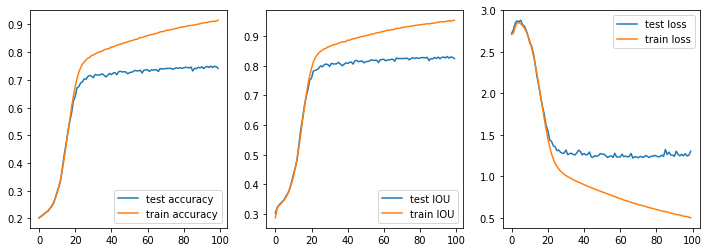

---------------------------------------------------------------------------------------------------- 



In [133]:
f = stats([tst1], [trn1], ephocs=100, params=[200])

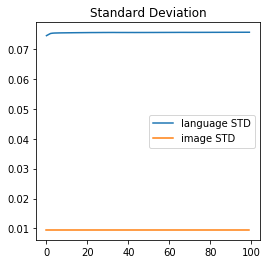

In [134]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD1_list, imgSTD1_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

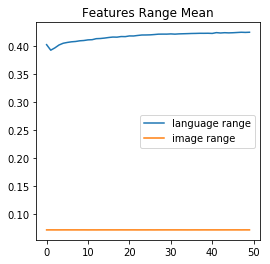

In [135]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange1_list, imgRange1_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
ephocs=50

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:50])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

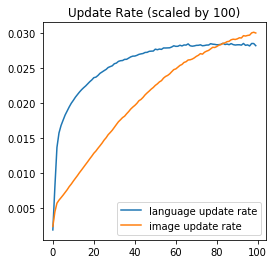

In [137]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq1, Gimg1]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
ephocs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(ephocs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()